In [1]:
import cv2
import json
# import wandb
import torch
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import PIL.Image as Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# wandb.login()
from sklearn.model_selection import train_test_split, StratifiedKFold

PATH_ANOT = '../project2_rcnn/input/train_data/ann'
PATH_IMG = '../project2_rcnn/input/train_data/img'
PATH_TEST_IMG = '../project2_rcnn/input/test_data'
PATH_MODEL = '../project2_rcnn/model_rcnn/fasterrcnn_resnet50_fpn.pth'
PATH_MODEL_FOLDS = '../project2_rcnn/model_rcnn/folds'

from pylab import rcParams
rcParams['figure.figsize'] = 15,10

## Same description for model && visual results

In [2]:
# train data
f = Path(PATH_ANOT) / '10065795965_9d015ff831_c.jpg.json'
with Path(f).open() as json_file:
    data = json.load(json_file) 
data

{'description': '',
 'tags': [{'id': 103841883,
   'tagId': 29127058,
   'name': '2',
   'value': 2,
   'labelerLogin': 'beifa',
   'createdAt': '2021-05-01T06:27:39.110Z',
   'updatedAt': '2021-05-01T06:27:39.110Z'}],
 'size': {'height': 512, 'width': 512},
 'objects': [{'id': 716649616,
   'classId': 2913023,
   'description': '',
   'geometryType': 'rectangle',
   'labelerLogin': 'beifa',
   'createdAt': '2021-05-01T06:27:48.536Z',
   'updatedAt': '2021-05-01T06:27:52.742Z',
   'tags': [],
   'classTitle': 'parrot',
   'points': {'exterior': [[128, 170], [200, 295]], 'interior': []}}]}

In [3]:
train_data,sizes,tags = [], [], []
for f, img in zip(sorted(Path(PATH_ANOT).glob('*.*')), sorted(Path(PATH_IMG).glob('*.*'))):
    with Path(f).open() as json_file:
        # load json
        data = json.load(json_file)
        # add imge to json
        data['image'] = cv2.cvtColor( cv2.imread(str(img)), cv2.COLOR_BGR2RGB)  
        train_data.append(data)
        # check tags
        if data['tags'] != []:
            tags.append(int(data['tags'][0]['name']))
        else: print(f)
print('Train data len: ', len(train_data), len(tags))
for i in train_data:
    sizes.append(list(data['size'].values()))
print(f'Train data parrot counts: {len(tags)}')
print(f'Big part on img: {np.bincount(tags)[1]},medium img: {np.bincount(tags)[2]},small: {np.bincount(tags)[3]},shape all images: {np.mean(sizes, axis =0)}')

Train data len:  94 94
Train data parrot counts: 94
Big part on img: 32,medium img: 46,small: 16,shape all images: [512. 512.]


### Tags

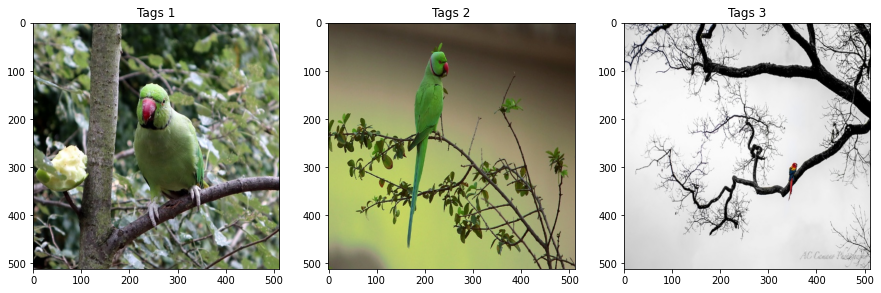

In [4]:
idx_one = np.where(np.array(tags) == 1)
idx_two = np.where(np.array(tags) == 2)
idx_three = np.where(np.array(tags) == 3)

img1 = np.take(train_data, np.random.choice(idx_one[0]))['image']
img2 = np.take(train_data, np.random.choice(idx_two[0]))['image'] 
img3 = np.take(train_data, np.random.choice(idx_three[0]))['image'] 
images = [img1, img2, img3]
for i in range(1):
    f, axarr = plt.subplots(1,3)
    for p in range(3):          
        axarr[p].imshow(images[p])
        axarr[p].set_title(f'Tags {p+1}')

## Model

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

class PT(Dataset):

    def __init__(self, data, transforms = None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
     
        dt = self.data[idx]        
        img = dt['image']        
        box_axis = dt['objects'][0]['points']['exterior']
        area = (box_axis[1][1] - box_axis[0][1]) * (box_axis[1][0] - box_axis[0][0])        
        boxes = torch.as_tensor(box_axis, dtype=torch.float32)
        boxes = boxes.reshape(-1, 4)

        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.ones((1), dtype = torch.long)
        target['image_id'] = torch.tensor([idx], dtype = torch.float32)
        target['area'] = torch.tensor(area, dtype = torch.float32)
        img = img / 255.0
        img = img.transpose(2, 0, 1).astype(np.float32)   
        if self.transforms is not None:
            img = self.transforms(img)   

        # torch.tensor(img, dtype = torch.float32) 
        return torch.tensor(img, dtype = torch.float32), target   

class PT_test(Dataset):

    def __init__(self, data, transforms = None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
         
        img = self.data[idx]
        img = img / 255.0
        img = np.transpose(img, (2,0,1))

        if self.transforms is not None:
            img = self.transforms(img)        
        return torch.tensor(img, dtype = torch.float32) , idx

<ipython-input-6-93fc4f35c1bb>:11: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(im,


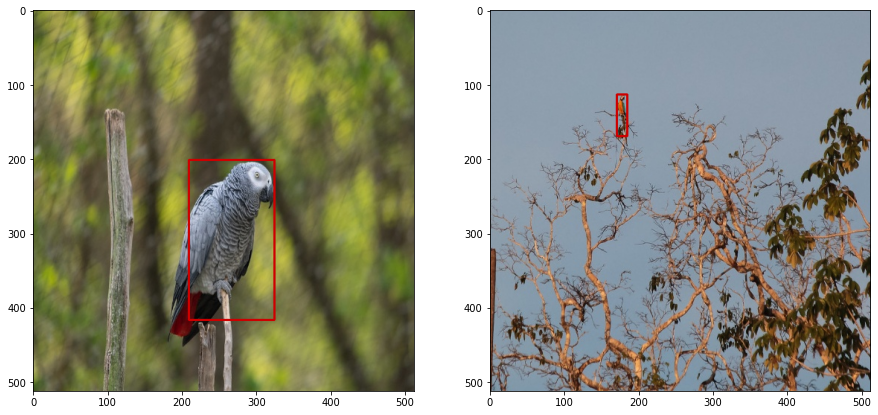

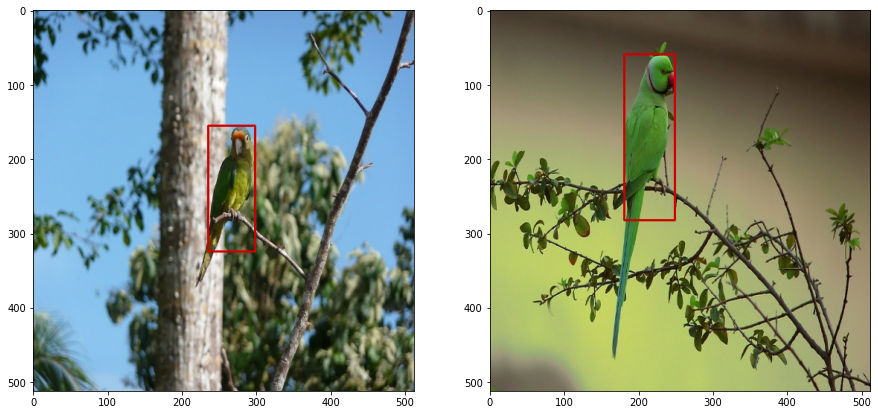

In [6]:
dataset = PT(train_data)

for i in range(2):
    f, axarr = plt.subplots(1,2)
    for p in range(2):     
        idx = np.random.randint(0, len(dataset))
        img, target = dataset[idx]
        bx = target['boxes'].cpu().numpy()[0]
        im = img.cpu().numpy() 
        im  = np.transpose((im * 255).astype(np.uint8), (1,2,0))
        cv2.rectangle(im,
                      (bx[0], bx[1]),
                      (bx[2], bx[3]),
                      (205,0,0), 2
                     )        
        axarr[p].imshow(im)

In [7]:
class PT_RRCNN(nn.Module):

    def __init__(self, num_classes: int = 2, test :bool = False):
        super().__init__()
        self.test = test
        if self.test:
            self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,
                                                                              pretrained_backbone=False)
        else:
            self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    def forward(self, x, y = None):
        if self.test:      
            return self.model(x)
        else:
            assert y is not None, f'target error PT_RRCNN, y : {y}'
            return self.model(x, y)

## Metrics

- Intersection Over Union(IOU)
  это показатель, который находит разницу между аннотациями достоверных данных и предсказанными ограничивающими рамками. 
  При обнаружении объектов модель прогнозирует несколько ограничивающих прямоугольников для каждого объекта и на основе оценок достоверности каждого ограничивающего прямоугольника удаляет ненужные прямоугольники на основе его порогового значения. 

Оценка Intersection over Union> 0,5 обычно считается «хорошим» прогнозом.


In [8]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

## Evaluate

In [9]:
# load test data

test_img = []
for img in Path(PATH_TEST_IMG).glob('*.*'):
    test_img.append(cv2.cvtColor( cv2.imread(str(img)), cv2.COLOR_BGR2RGB)) 

len(test_img)

20

In [10]:
dataset_test = PT_test(test_img)#, transform)
test_loader =  DataLoader(dataset_test,
                          batch_size=1,
                          num_workers=2, 
                          collate_fn=collate_fn
                         )

def evaluate(model, loader):    
    model.eval()
    model.to(device)
    with torch.no_grad():
        out = []
        for images,i in loader:  
            images = list(image.float().to(device) for image in images)
            outputs = model(images)
            out.append(outputs)
    return out 

model = PT_RRCNN(test=True)
model.load_state_dict(torch.load(PATH_MODEL))

<All keys matched successfully>

In [11]:
out = evaluate(model, test_loader)

## Visual result

<ipython-input-13-a8c9e4143e09>:11: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(im,


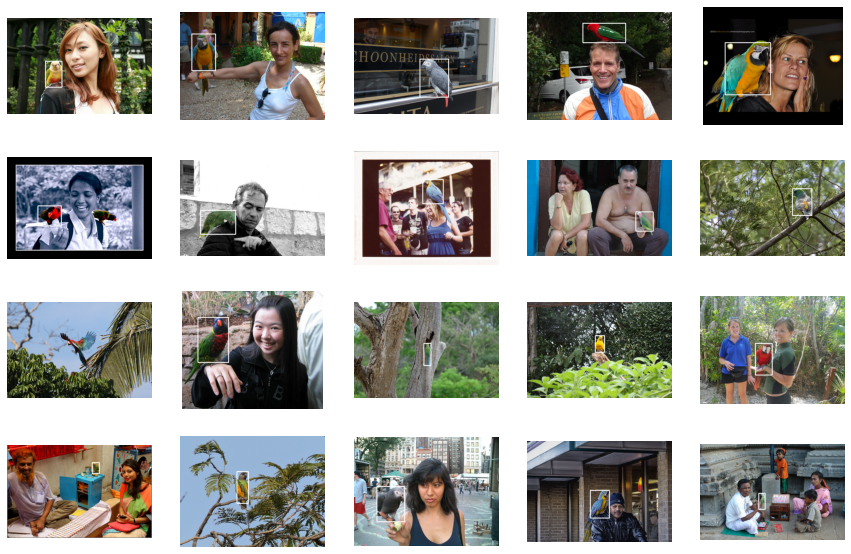

In [13]:
detection_threshold = 0.5
for i in range(1, len(test_img)+1):
    plt.subplot(4, 5, i) 
    im = test_img[i-1]
    b = out[i-1][0]['boxes'].data.cpu().numpy()
    if len(b) > 0:
        s = out[i-1][0]['scores'].data.cpu().numpy()        
        bx = b[s>=detection_threshold]
        if len(bx) > 0:
            bx = bx[0]
            cv2.rectangle(im,
                  (bx[0], bx[1]),
                  (bx[2], bx[3]),
                  (255,255,255), 4)
    plt.imshow(im)
    plt.axis('off')
plt.show()

## Visual folds

In [31]:
# predict fold result
np.mean([0.7906, 0.7209, 0.7843, 0.7850,0.715])

0.75916

In [14]:
# all fold score
def evaluate(model, fold: int, loader)->list:  
    model.load_state_dict(torch.load(Path(PATH_MODEL_FOLDS) / f'fasterrcnn_resnet50_fpn_{fold}.pth'))
    model.eval()
    model.to(device)
    with torch.no_grad():
        out = []
        for images,i in loader:  
            images = list(image.float().to(device) for image in images)
            outputs = model(images)
            out.append(outputs)
    return out 

In [15]:
tmp_out = []
model = PT_RRCNN(test=True)
for f in range(5):
    out = evaluate(model, f, test_loader)
    tmp_out.append(out)

In [16]:
tmp_fold = []
detection_threshold = 0.5
for j in range(len(test_img)):
    im = test_img[j]
    color = [
          (0,0,255),
          (0,255,255),
          (255,0,255),
          (10,0,255),
          (255,255,0)
          ]
    for i, d in enumerate(np.asarray(tmp_out)[:, j].ravel()):
        b = d['boxes'].data.cpu().numpy()
        if len(b) > 0:
            s = d['scores'].data.cpu().numpy() 
            bx = b[s>=detection_threshold]
            if len(bx) > 0:
                bx = bx[0]
                cv2.rectangle(im,
                    (bx[0], bx[1]),
                    (bx[2], bx[3]),
                    color[i], 2)
    im = cv2.resize(im, (799,533))
    tmp_fold.append(im)

<ipython-input-16-33e1151d23c0>:19: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(im,


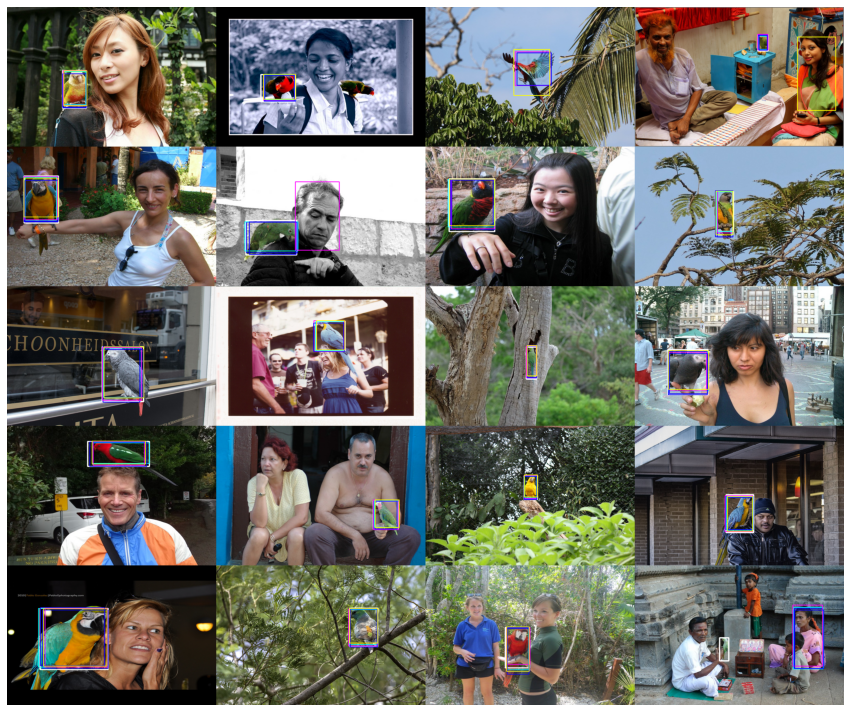

In [18]:
plt.figure(figsize=(15, 15))
plt.imshow(np.concatenate(np.array(tmp_fold).reshape(4, 533*5,799,3), axis= 1));
plt.axis('off');